Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice
from copy import deepcopy, copy
from random import random, randint
from tqdm.auto import tqdm
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [2]:
State = namedtuple('State', ['x', 'o'])

In [3]:
MAGIC = [2, 7, 6, 9, 5, 1, 4, 3, 8]

In [4]:
def print_board(pos):
    """Nicely prints the board"""
    for r in range(3):
        for c in range(3):
            i = r * 3 + c
            if MAGIC[i] in pos.x:
                print('X', end='')
            elif MAGIC[i] in pos.o:
                print('O', end='')
            else:
                print('.', end='')
        print()
    # print()

In [5]:
def win(elements):
    """Checks is elements is winning"""
    return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
    """Evaluate state: +1 first player wins"""
    if win(pos.x):
        return 10
    elif win(pos.o):
        return -100
    else:
        return 0

In [6]:
def possible_actions(state:State):
        return [i for i in range(1, 9+1) if i not in state.x and i not in state.o]

def random_action(state: State):
    actions = possible_actions(state)
    return actions[randint(0, len(actions) - 1)]

In [7]:
class QLearner:
    q = defaultdict(float)
    prev_state = None
    prev_action = None
    def __init__(self, epsilon = 0.80, learning_rate = 0.8, discount_factor = 0.9):
        self.epsilon = epsilon                      
        self.learning_rate = learning_rate          
        self.discount_factor = discount_factor    
    
    def get_action(self, state:State, learn):
        actions = possible_actions(state)
        if random() < self.epsilon or not learn:
            q_values = [self.q[(state, i)] for i in actions]
            return actions[np.argmax(q_values)]
        else:
            return actions[randint(0, len(actions) - 1)]
    
    def get_maxQ(self, state:State):
        return max(self.q[(state, action)] for action in possible_actions(state))
    
    @staticmethod
    def invert_state(state: State):
        return State(state.o, state.x)
    
    def move(self, state:State, learn=False):
        action = self.get_action(state, learn)
        state_moved = State((*state.x, action), (*state.o,))
        if learn:
            if self.prev_state is not None:
                old_q = self.q[(self.prev_state, self.prev_action)]
                max_q = self.get_maxQ(state)
                reward = state_value(state_moved)
                if reward == 0:
                    reward = -1
                self.q[(self.prev_state, self.prev_action)] = (1 - self.learning_rate) * old_q + self.learning_rate * (reward + self.discount_factor * max_q)
                if reward > 0:  #terminal win(update also last move q)
                    old_q = self.q[(state, action)]
                    self.q[(state, action)] = (1 - self.learning_rate) * old_q + self.learning_rate * reward
        self.prev_state = state
        self.prev_action = action
        return state_moved
    
    def end_play(self):
        self.prev_state = None
        self.prev_action = None
    
    def loss(self, state):
        old_q = self.q[(self.prev_state, self.prev_action)]
        reward = state_value(state)
        self.q[(self.prev_state, self.prev_action)] =  (1 - self.learning_rate) * old_q + self.learning_rate * reward
        

In [8]:
class RandomPlayer:
    def move(self, state:State):
        action = random_action(state)
        next_state = State(state.x, (*state.o, action))
        return next_state

  0%|          | 0/1000000 [00:00<?, ?it/s]

218155


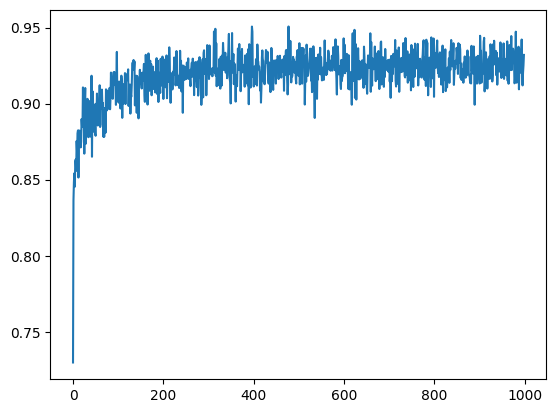

In [9]:
epochs = 1_000_000
history = []
history_step = 1000
step_win = 0
step_loss = 0
q_agent = QLearner()
rnd_agent = RandomPlayer()

for i in tqdm(range(epochs)):
    q_agent.end_play()
    state = State((), ())
    while True:
        state = q_agent.move(state, learn=True)
        if win(state.x):
            step_win += 1
            break
        if len(possible_actions(state)) == 0:
            #draw
            break
        state = rnd_agent.move(state)
        if win(state.o):
            q_agent.loss(state)
            step_loss += 1
            break
    if i != 0 and i%history_step == 0:
        history.append(step_win / (step_win+step_loss))
        step_win = 0
        step_loss = 0
        
print(len(q_agent.q))
plt.plot(history)

In [11]:
epochs = 100_000
history = []
q_agent = QLearner()
rnd_agent = RandomPlayer()

for i in tqdm(range(epochs)):
    story = []
    state = State((), ())
    while True:
        state = q_agent.move(state)
        story.append(state)
        if win(state.x):
            history.append(1)
            break
        if len(possible_actions(state)) == 0:
            break
        state = rnd_agent.move(state)
        story.append(state)
        if win(state.o):
            history.append(0)
            break
print(f"Win rate: {statistics.mean(history)}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Win rate: 0.9912158892465652
